In [34]:
from numpy import *
from pandas import read_csv
from matplotlib.pyplot import *
n = 1.00866491588 #u
p = 1.007276466621 #u
uc2 = 931.49410242 # MeV

In [35]:
Data = read_csv("all_nuclei.csv")
toremove = []
for i in Data.index:
    if(Data["N"][i]> 3*Data["Z"][i]):
        toremove.append(i)
Data = Data.drop(toremove)
N = Data["N"]
Z = Data["Z"]
A = N+Z
M = Data["mass"] # in 'u'
BE = (N*n+Z*p-M)*uc2 # in MeV
Data["BE"] = BE
Data["BE/A"] = BE/A
Data.columns

Index(['Z', 'N', 'mass', 'energy_double', 'spin_string', 'parity', 'BE',
       'BE/A'],
      dtype='object')

In [36]:
Del0 = 1 #MeV
aPt  = A**(-1/2)
for i in Data.index:
    if A[i]%2 == 0:
        aPt[i] = 0
    elif Z[i]%2==1:
        aPt[i] = -aPt[i]
aVt = A
aSt = -A**(2/3)
aCt = -Z*(Z-1)*A**(-1/3)
aAt = -((N-Z)**2)/A

[15.57075537 18.21307623  0.71894211 22.43669662  0.07231096]


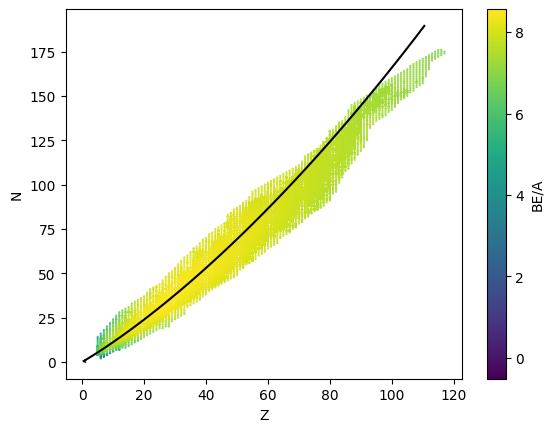

In [37]:
X = array([aVt,aSt,aCt,aAt,aPt]).T
y = array(BE)
XTX = X.T @ X
pseudoinverse = linalg.inv(XTX) @ X.T
coeff = dot(pseudoinverse,y)
aV,aS,aC,aA,aP = coeff
print(coeff)
Data = Data.drop(Data.index[:300])
Data.plot.scatter("Z","N",color ="BE/A",s=0.3,colormap='viridis')
A = linspace(1,300,100)
Z = (4*aA+aC*A**(-1/3))/(8*aA/A + 2*aC*A**(-1/3))
N = A-Z
plot(Z,N,'black')
show()

[15.57088919 18.21348923  0.71895247 22.4367921 ]


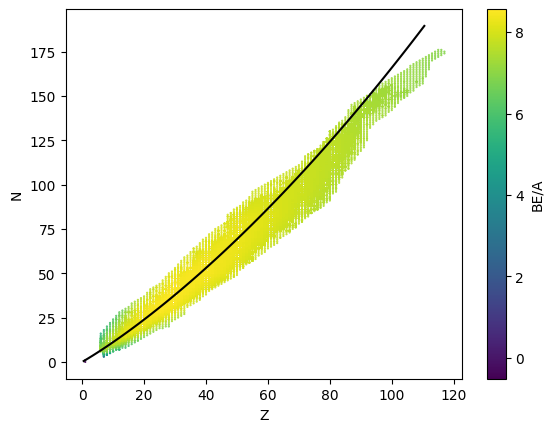

In [38]:
X = array([aVt,aSt,aCt,aAt]).T
XTX = X.T @ X
pseudoinverse = linalg.inv(XTX) @ X.T
coeff = dot(pseudoinverse,y)
aV,aS,aC,aA = coeff
print(coeff)
Data = Data.drop(Data.index[:300])
Data.plot.scatter("Z","N",color ="BE/A",s=0.3,colormap='viridis')
A = linspace(1,300,100)
Z = (4*aA+aC*A**(-1/3))/(8*aA/A + 2*aC*A**(-1/3))
N = A-Z
plot(Z,N,'black')
show()

In [49]:
theta = zeros(4)
y2 = dot(y,y)
XTy = dot(X.T,y) 
XTX = X.T @ X
N = y.shape[0]

def L(theta):
    MSE = y2
    MSE += -2*dot(XTy,theta)
    MSE += dot(theta,dot(XTX,theta))
    #error = y - dot(X,theta)
    #MSE = mean(error**2)
    return MSE

def grad(theta):
    toret = dot(XTX,theta)
    toret -= XTy
    toret = 2*toret
    return toret

g = grad(theta)
L0 = L(theta)
print(L0,theta)
h = 1
while L0 > 5*10**6:
    g2 = dot(g,g)
    while L(theta-g*h) < L0:
        h = h*2
    while L0 - L(theta-g*h) < g2*h/2:
        h = h/2
    theta = theta - g*h
    g = g - 2*h*dot(XTX,g)
    #g = grad(theta)
    L0 = L(theta)
print(L0,theta)


210315520496.8885 [0. 0. 0. 0.]
4999982.780090332 [13.53523982 11.8542687   0.58001089 17.36077435]


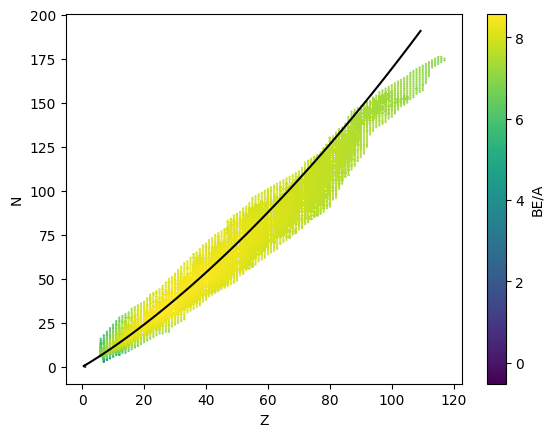

In [50]:
aV,aS,aC,aA = theta
Data.plot.scatter("Z","N",color ="BE/A",s=0.3,colormap='viridis')
A = linspace(1,300,100)
Z = (4*aA+aC*A**(-1/3))/(8*aA/A + 2*aC*A**(-1/3))
N = A-Z
plot(Z,N,'black')
show()